In [ ]:
class Interval:
    def __init__(self, low, high):
        self.low = low
        self.high = high

    @property
    def mid(self):
        return (self.low + self.high) / 2

    @property
    def rad(self):
        return (self.high - self.low) / 2

    @property
    def wid(self):
        return self.high - self.low

    def __add__(self, other):
        return Interval(self.low + other.low, self.high + other.high)

    def __sub__(self, other):
        return Interval(self.low - other.high, self.high - other.low)

    def __mul__(self, other):
        values = [self.low * other.low, self.low * other.high, self.high * other.low, self.high * other.high]
        return Interval(min(values), max(values))

    def __truediv__(self, other):
        other_reciprocal = Interval(1 / other.high, 1 / other.low)
        return self * other_reciprocal

    def union(self, other):
        return Interval(min(self.low, other.low), max(self.high, other.high))

    def intersect(self, other):
        return Interval(max(self.low, other.low), min(self.high, other.high))

    def inside(self, other):
        return self.low > other.low and self.high < other.high

    def __str__(self):
        return f'[{self.low}, {self.high}]'

    def __repr__(self):
        return str(self)

J_low = 0.3340455, J_high = 0.335229
midJ = 0.33463725, radJ = 0.000591750000000002, widJ = 0.001183500000000004
mode [0.33457329999999996, 0.3345819], max_mu = 70
k = [149, 150, 151, 152, 153, 154, 155, 156, 157]
omega = 4.917500000000672, beta = 0.33463725
Ji = -0.6620194338825901
rho = 0.007266582171546451


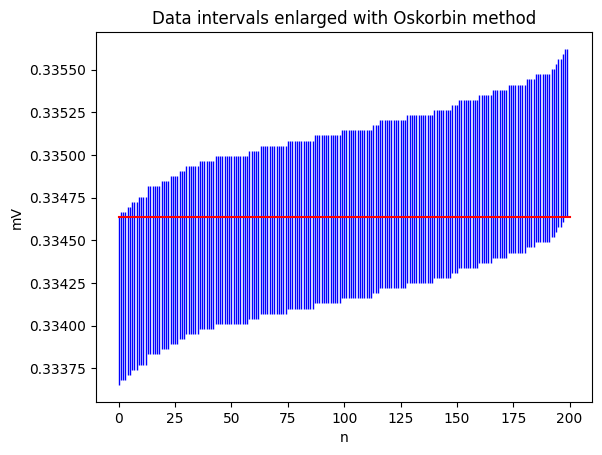

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os


def load_csv(filename: str) -> np.ndarray:
    data = []
    with open(filename) as file:
        reader = csv.reader(file, delimiter=";")
        for row in reader:
            data.append([float(row[0]), float(row[1])])
    return np.array(data).T[0]


def draw_data(data: np.ndarray, folder=".", ext="pdf"):
    cur_count = 0
    prev_count = 0
    cur_level = data[0]
    for value in data:
        if value == cur_level:
            cur_count += 1
        else:
            plt.plot([prev_count, cur_count], [cur_level, cur_level], 'b')
            cur_count += 1
            prev_count = cur_count
            cur_level = value
    plt.plot([prev_count, cur_count], [cur_level, cur_level], 'b')
    plt.title("Experiment data")
    plt.xlabel("n")
    plt.ylabel("mV")

    if not os.path.isdir(folder):
        os.makedirs(folder)

    plt.savefig(f"{folder}/data.{ext}")


def draw_intervals(interval_data, folder=".", ext="pdf"):
    plt.clf()
    for i in range(len(interval_data)):
        plt.vlines(i, interval_data[i].low, interval_data[i].high, colors="b", lw=1)
    plt.title('Data intervals')
    plt.xlabel('n')
    plt.ylabel('mV')

    if not os.path.isdir(folder):
        os.makedirs(folder)

    plt.savefig(f"{folder}/data_int.{ext}")


def inject_uncertainty(data, eps=1e-4):
    return np.array([Interval(value - eps, value + eps) for value in data])


def calculateJ(interval_data):
    return Interval(min([value.low for value in interval_data]), max([value.high for value in interval_data]))


def calculate_mode(interval_data):
    array_of_edges = []
    for interval in interval_data:
        array_of_edges.append(interval.low)
        array_of_edges.append(interval.high)

    array_of_edges.sort()

    submode_intervals = [Interval(array_of_edges[i], array_of_edges[i + 1]) for i in range(len(array_of_edges) - 1)]
    mu = [[interval.inside(value) for value in interval_data].count(True) for interval in submode_intervals]
    max_mu = max(mu)
    k = list(filter(lambda index: mu[index] == max_mu, range(len(submode_intervals))))
    mode = submode_intervals[k[0]]
    for interval in [submode_intervals[i] for i in k]:
        mode = mode.union(interval)

    return mode, submode_intervals, mu, k


def draw_intervals_including_mode(interval_data, mode, folder=".", ext="pdf"):
    plt.clf()
    for i in range(len(interval_data)):
        color = "r" if mode.inside(interval_data[i]) else "b"
        plt.vlines(i, interval_data[i].low, interval_data[i].high, colors=color, lw=1)

    plt.plot([0, len(interval_data)], [mode.low, mode.low], color="r", ls='--', lw=1)
    plt.plot([0, len(interval_data)], [mode.high, mode.high], color="r", ls='--', lw=1)

    plt.title('Data intervals including mode')
    plt.xlabel('n')
    plt.ylabel('mV')

    if not os.path.isdir(folder):
        os.makedirs(folder)

    plt.savefig(f"{folder}/data_int_mode.{ext}")


def draw_mode_frequencies(interval_data, mu, k, folder=".", ext="pdf"):
    x = [value.mid for value in interval_data]
    plt.clf()

    plt.plot(x, mu)
    plt.vlines([interval_data[k[0]].low, interval_data[k[-1]].high], [0, 0], [max(mu), max(mu)], color='r', ls='--')

    plt.title("Mode frequencies")
    plt.xlabel("mV")
    plt.ylabel("$\mu$")

    if not os.path.isdir(folder):
        os.makedirs(folder)

    plt.savefig(f"{folder}/mode_freq.{ext}")


def oskorbin_optimization(interval_data):
    c = [1, 0]
    A = []
    b = []
    for interval in interval_data:
        A.append([-interval.rad, -1])
        b.append(-interval.mid)
        A.append([-interval.rad, 1])
        b.append(interval.mid)
    omega_bound = (1, None)
    beta_bound = (None, None)
    bounds = [omega_bound, beta_bound]

    res = scipy.optimize.linprog(c, A_ub=A, b_ub=b, bounds=bounds)

    return res.x[0], res.x[1]


def draw_oskorbin_optimization_results(interval_data, omega, beta, folder=".", ext="pdf"):
    new_data = [Interval(interval.mid - omega * interval.rad, interval.mid + omega * interval.rad) for interval in interval_data]
    plt.clf()
    for i in range(len(interval_data)):
        plt.vlines(i, new_data[i].low, new_data[i].high, colors="b", lw=1)
    plt.plot([0, len(new_data)], [beta, beta], color='r')
    plt.title('Data intervals enlarged with Oskorbin method')
    plt.xlabel('n')
    plt.ylabel('mV')

    if not os.path.isdir(folder):
        os.makedirs(folder)

    plt.savefig(f"{folder}/oskorbin.{ext}")


def data_intersection(interval_data):
    intersection = interval_data[0]
    for interval in interval_data:
        intersection = intersection.intersect(interval)
    return intersection


def data_union(interval_data):
    union = interval_data[0]
    for interval in interval_data:
        union = union.union(interval)
    return union


def jakkar_index(interval_data):
    return data_intersection(interval_data).wid / data_union(interval_data).wid


def related_mode_width(interval_data, mode):
    return mode.wid / data_union(interval_data).wid


data = load_csv("Channel_1_500nm_0_23mm.csv")
draw_data(data, folder="figures", ext="png")

data = inject_uncertainty(data)
draw_intervals(data, folder="figures", ext="png")

J = calculateJ(data)
print(f"J_low = {J.low}, J_high = {J.high}")
print(f"midJ = {J.mid}, radJ = {J.rad}, widJ = {J.wid}")
mode, submode_intervals, mu, k = calculate_mode(data)
print(f"mode {mode}, max_mu = {max(mu)}")
print(f"k = {k}")

draw_intervals_including_mode(data, mode, folder="figures", ext="png")
draw_mode_frequencies(submode_intervals, mu, k, folder="figures", ext="png")

omega, beta = oskorbin_optimization(data)
print(f"omega = {omega}, beta = {beta}")
draw_oskorbin_optimization_results(data, omega, beta, folder="figures", ext="png")

print(f"Ji = {jakkar_index(data)}")
print(f"rho = {related_mode_width(data, mode)}")

In [ ]:
!python --version

Python 3.10.11
